### Import all the libraries 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
!pip install torch-summary==1.4.4 # for DenseNet121
from torchvision import models
from torchsummary import summary

import numpy as np 
from matplotlib import pyplot as plt 
import matplotlib.ticker as mticker

import pandas as pd
from sklearn.metrics import classification_report

import os
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import sys

sys.path.append('/kaggle/input/myscripts/tensorflow2/default/1')

import prototypical_network
import train_and_evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Preprocessing the images

In [3]:
import cv2
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import matplotlib.pyplot as plt

class CFG:
    SEED= 42
    TF_SEED= 768
    HEIGHT= 224
    WIDTH= 224
    CHANNELS= 3
    IMAGE_SIZE=(224,224,3)


augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-.01, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED)
], name='augmentation_layer')

def check_image_path(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]

def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced_image = clahe.apply(gray_image)
    enhanced_image_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)
    return enhanced_image_rgb

def display_image_comparison(original_image, enhanced_image):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    axes[1].imshow(enhanced_image)
    axes[1].set_title("Image after CLAHE")
    axes[1].axis('off')
    plt.show()

def read_xray_images(directory_path, img_height, img_width, selected_classes=None, augmentation=True, 
                     normalize=False, apply_clahe_flag=True, display_comparison=False):
    datax = [] 
    datay = [] 
    
   
    sub_directories = os.listdir(directory_path)
    
    if selected_classes is None:
        selected_classes = sub_directories
    else:
        for cls in selected_classes:
            if cls not in sub_directories:
                raise ValueError(f"Class '{cls}' not found in {directory_path}. Available classes: {sub_directories}")
    
    for sub_dir in selected_classes:
        sub_dir_path = os.path.join(directory_path, sub_dir)
        correct_image_filepaths = check_image_path(sub_dir_path)
        
        for fpath in correct_image_filepaths:
            image = cv2.imread(fpath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (img_width, img_height))
            
            if apply_clahe_flag:
                enhanced_image = apply_clahe(image)
                image = enhanced_image  # Use the enhanced image
            
            if augmentation:
                # Apply the augmentation layer
                image = tf.convert_to_tensor(image, dtype=tf.float32)
                image = augmentation_layer(image)  # Apply augmentation layer
                
            if normalize:
                image = image / 255.0  # Normalize pixel values to [0, 1]
                
            if display_comparison:
                display_image_comparison(image, enhanced_image)
                
            datax.append(image)
            datay.append(sub_dir)
    
    return np.array(datax), np.array(datay)


### Download pre-trained model

In [4]:
resnet50_model = models.resnet50(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


### Model architecture

In [5]:
resnet50_model = resnet50_model.to(device)
print(resnet50_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Summarize model

In [6]:
summary(resnet50_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

### Model layers and their child modules

In [7]:
for name, module in resnet50_model.named_modules():
    print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.conv2
layer1.0.bn2
layer1.0.conv3
layer1.0.bn3
layer1.0.relu
layer1.0.downsample
layer1.0.downsample.0
layer1.0.downsample.1
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.conv2
layer1.1.bn2
layer1.1.conv3
layer1.1.bn3
layer1.1.relu
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.conv2
layer1.2.bn2
layer1.2.conv3
layer1.2.bn3
layer1.2.relu
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.conv2
layer2.0.bn2
layer2.0.conv3
layer2.0.bn3
layer2.0.relu
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.conv2
layer2.1.bn2
layer2.1.conv3
layer2.1.bn3
layer2.1.relu
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.conv2
layer2.2.bn2
layer2.2.conv3
layer2.2.bn3
layer2.2.relu
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.conv2
layer2.3.bn2
layer2.3.conv3
layer2.3.bn3
layer2.3.relu
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.conv2
layer3.0.bn2
layer3.0.conv

In [8]:
print(f"---Main modules---")
for name, module in resnet50_model.named_children():
    print(name)
    
print(f"---Child Modules for the 'layer4' module")
for name, module in resnet50_model.named_children():
    if name == "layer4":
        for n, m in module.named_children():
            print(n)

---Main modules---
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
---Child Modules for the 'layer4' module
0
1
2


In [9]:
for param in resnet50_model.parameters():
    param.requires_grad = False

### Flatten outputs from the Convolutional base networks and remove the Linear layers

In [10]:
resnet50_model.fc = nn.Flatten()
summary(resnet50_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

### Unfreeze the layers you want for fine-tuning

In [11]:
for param in resnet50_model.layer4[2:].parameters():
    param.requires_grad = True

In [12]:
summary(resnet50_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

In [13]:
img_height, img_width = 224, 224 
train_data_dir = r"/kaggle/input/thoraric-disease-dataset/Few Shot Algorithm/Training"
validation_data_dir = r"/kaggle/input/thoraric-disease-dataset/Few Shot Algorithm/Validation"
test_data_dir = r"/kaggle/input/thoraric-disease-dataset/Few Shot Algorithm/Testing"

In [14]:
%%time
train_data_dir = train_data_dir
x_train, y_train = read_xray_images(train_data_dir, img_height, img_width, augmentation=True)
x_train.shape, y_train.shape

CPU times: user 2.85 s, sys: 445 ms, total: 3.3 s
Wall time: 3.68 s


((60, 224, 224, 3), (60,))

In [15]:
validation_data_dir = validation_data_dir
x_val, y_val = read_xray_images(validation_data_dir, img_height, img_width, augmentation=True)
x_val.shape, x_val.shape

((60, 224, 224, 3), (60, 224, 224, 3))

### Display Sample Images

Class labels sampled: ['Atelectasis' 'Cardiomegaly']


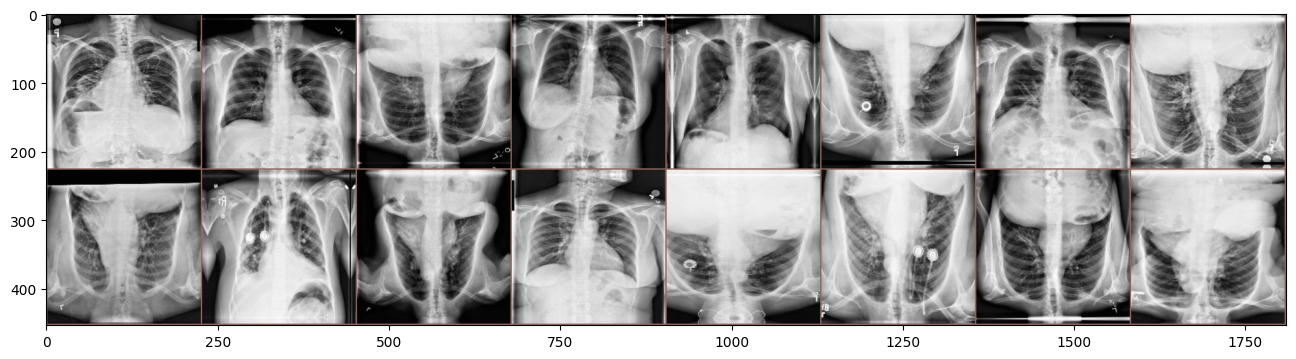

In [16]:
n_way = 2     
n_support = 5 
n_query = 3   
sample_example = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_train, y_train)
train_and_evaluation.display_sample(sample_example['images'])
print(f"Class labels sampled: {sample_example['class_labels']}")

### Train a Prototypical Network using a fine-tuned base model

In [ ]:
import gc def report_gpu(): print(torch.cuda.list_gpu_processes()) gc.collect() torch.cuda.empty_cache()

model = prototypical_network.ProtoNet(resnet50_model, device)
model.to(device)

basic_learning_rate = 0.0005

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=basic_learning_rate/10)

n_way = 2       
n_support = 3   
n_query = 10

validation_episodes = 20
train_episodes = 20

max_epoch = 20

filename = "ResNettrain-best-few-shot-model-2-way-3-shot.pt"

train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list = train_and_evaluation.run_training_and_evaluation(model, x_train, y_train, x_val, y_val, n_way, n_support, n_query, train_episodes, validation_episodes, optimizer, max_epoch, filename)

average_train_accuracy = sum(train_accuracy_list) / len(train_accuracy_list)
average_validation_accuracy = sum(validation_accuracy_list) / len(validation_accuracy_list)


print(f"Average Training Accuracy: {average_train_accuracy:.2f}%")
print(f"Average Validation Accuracy: {average_validation_accuracy:.2f}%")

In [ ]:
results = {
    "Epoch": list(range(1, max_epoch + 1)),
    "Train Loss": train_loss_list,
    "Train Accuracy": train_accuracy_list,
    "Validation Loss": validation_loss_list,
    "Validation Accuracy": validation_accuracy_list
}

df = pd.DataFrame(results)

df.to_csv("/kaggle/working/resnet_training_results.csv", index=False)

df.to_pickle("/kaggle/working/resnet_training_results.pkl")
results = {
    "Epoch": list(range(1, max_epoch + 1)),
    "Train Loss": train_loss_list,
    "Train Accuracy": train_accuracy_list,
    "Validation Loss": validation_loss_list,
    "Validation Accuracy": validation_accuracy_list
}

In [ ]:
img_height, img_width = 224, 224
data_dir = test_data_dir
selected_classes = ['Covid19', 'Effusion']

x_test, y_test = read_xray_images(
    data_dir,
    img_height,
    img_width,
    selected_classes=selected_classes,
    augmentation=False
)

### 2 Way 3 Shot ResNet Testing

In [ ]:
prototypical_model = prototypical_network.ProtoNet(resnet50_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 3
n_query = 25

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
results = {
    "Test Loss": [test_loss],
    "Test Accuracy (%)": [test_accuracy * 100]
}

df_results = pd.DataFrame(results)
df_results.to_csv('/kaggle/working/prototypical_model_test_results_resnet_2way_3shot.csv', index=False)
print("Test results saved to /kaggle/working/prototypical_model_test_results_resnet_2way_3shot.csv")

### 2 Way 3 Shot Prediction

In [ ]:
prototypical_model.to(device)
n_way = 2
n_support = 3
n_query = 25 

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [ ]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data)

df_results.to_csv('/kaggle/working/prototypical_model_results_resnet_2way_3shot.csv', index=False)

print("Results saved to /kaggle/working/prototypical_model_results_resnet_2way_3shot.csv")

### 2 Way 3 Shot Classification Report

In [ ]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()


class_labels = sample_images["class_labels"]
label_mapping = {i: label for i, label in enumerate(class_labels)}


report = classification_report(y_true_flat, y_pred_flat, target_names=class_labels)
print(report)

### ROC Curve

In [ ]:
y_true_flat = results["y_true"].flatten() 
y_scores = results["y_pred"].flatten()    


fpr, tpr, thresholds = roc_curve(y_true_flat, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

cmap = plt.cm.Blues  

plt.figure(figsize=(8, 6))

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
disp.plot(cmap=cmap, values_format='d')


plt.title("Confusion Matrix", fontsize=12, pad=20)
plt.grid(False)

plt.colorbar(disp.im_, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### 2 Way 5 Shot ResNet Testing

In [ ]:
prototypical_model = prototypical_network.ProtoNet(resnet50_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 5
n_query = 25

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
results = {
    "Test Loss": [test_loss],
    "Test Accuracy (%)": [test_accuracy * 100]
}


df_results = pd.DataFrame(results)
df_results.to_csv('/kaggle/working/prototypical_model_test_results_resnet_2way_5shot.csv', index=False)
print("Test results saved to /kaggle/working/prototypical_model_test_results_resnet_2way_5shot.csv")

### 2 Way 5 Shot Prediction

In [ ]:
prototypical_model.to(device)
n_way = 2
n_support = 5
n_query = 25 

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [ ]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data) 


df_results = pd.DataFrame(csv_data)
df_results.to_csv('/kaggle/working/prototypical_model_results_resnet_2way_5shot.csv', index=False)
print("Results saved to /kaggle/working/prototypical_model_results_resnet_2way_5shot.csv")



## 2 way 5 shot Classification Report

In [ ]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()


class_labels = sample_images["class_labels"]
label_mapping = {i: label for i, label in enumerate(class_labels)}


report = classification_report(y_true_flat, y_pred_flat, target_names=class_labels)
print(report)

### Plot ROC Curve

In [ ]:
y_true_flat = results["y_true"].flatten()  
y_scores = results["y_pred"].flatten()    


fpr, tpr, thresholds = roc_curve(y_true_flat, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

cmap = plt.cm.Blues  

plt.figure(figsize=(8, 6))

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
disp.plot(cmap=cmap, values_format='d')


plt.title("Confusion Matrix", fontsize=12, pad=20)
plt.grid(False)

plt.colorbar(disp.im_, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### 3 Way 5 Shot ResNet Training

In [ ]:
img_height, img_width = 224, 224
data_dir = test_data_dir
selected_classes = ['Covid19', 'Effusion','Pneumonia']

x_test, y_test = read_xray_images(
    data_dir,
    img_height,
    img_width,
    selected_classes=selected_classes,
    augmentation=False
)
x_test.shape,y_test.shape

In [ ]:
prototypical_model = prototypical_network.ProtoNet(resnet50_model, device)
prototypical_model.to(device)

n_way = 3
n_support = 5
n_query = 25

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
results = {
    "Test Loss": [test_loss],
    "Test Accuracy (%)": [test_accuracy * 100]
}


df_results = pd.DataFrame(results)
df_results.to_csv('/kaggle/working/prototypical_model_test_results_resnet_3way_5shot.csv', index=False)
print("Test results saved to /kaggle/working/prototypical_model_test_results_resnet_3way_5shot.csv")

### 3 Way 5 Shot ResNet Prediction

In [ ]:
prototypical_model.to(device)
n_way = 3
n_support = 5
n_query = 25 

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [ ]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data) 


df_results = pd.DataFrame(csv_data)
df_results.to_csv('/kaggle/working/prototypical_model_results_resnet_3way_5shot.csv', index=False)
print("Results saved to /kaggle/working/prototypical_model_results_resnet_3way_5shot.csv")


### Classification Report

In [ ]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()


class_labels = sample_images["class_labels"]
label_mapping = {i: label for i, label in enumerate(class_labels)}


report = classification_report(y_true_flat, y_pred_flat, target_names=class_labels)
print(report)

### Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

cmap = plt.cm.Blues  

plt.figure(figsize=(8, 6))

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
disp.plot(cmap=cmap, values_format='d')


plt.title("Confusion Matrix", fontsize=12, pad=20)
plt.grid(False)

plt.colorbar(disp.im_, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### ROC Curve

In [ ]:
y_true_flat = results["y_true"].flatten()  
y_scores = results["y_pred"].flatten()    


fpr, tpr, thresholds = roc_curve(y_true_flat, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()